In [1]:
 #!nvidia-smi

In [3]:
from utils.cloudant_utils import cloudant_db as db
import numpy as np
import pandas as pd

In [4]:
repos = [r for r in db.get_query_result({"type": "release"}, ["_id", "releases"], limit=10000, raw_result=True)["docs"]]
repos[0]['releases'][0].keys()

dict_keys(['repo', 'release_tag', 'release_date', 'downloads', 'stars', 'watchers', 'forks', 'commits', 'issues', 'total_stars', 'total_forks', 'total_commits', 'contributors', 'total_issues', 'total_closedIssues', 'closedIssues', 'readme', 'readme_size'])

In [5]:
values = [r for release in repos for r in release["releases"]]
df = pd.DataFrame(values)
df['contributors'] = df['contributors'].apply(lambda x:
                                              [i for i in x if i is not None] if isinstance(x, list)
                                              else [])

In [6]:
df.shape

(44043, 19)

In [7]:
df = df[~df['readme'].isnull()]

In [8]:
new_df = df.groupby("repo").agg({"readme": list,
                                 "stars": sum,
                                 "forks": sum,
                                 "downloads": sum,
                                 "contributors": sum})

In [9]:
readme1 =  new_df.iloc[2]['readme'][0]
readme2 = new_df.iloc[2]['readme'][1]
# print(len(new_df))
# new_df[new_df['readme'].map(lambda d: len(d)) > 0]

In [10]:
new_df['600stars']= np.where(new_df['stars'] > 600, 1, 0)

In [11]:
new_df.loc[new_df['600stars'] == 1].sample(5)[['readme', '600stars']]

,readme,600stars
repo,,
DerwenAI/pytextrank,[# PyTextRank\n\n**PyTextRank** is a Python im...,1
ultralytics/yolov3,"[<img src=""https://storage.googleapis.com/ultr...",1
ramitsurana/awesome-kubernetes,[# Awesome-kubernetes [![Awesome](https://cdn....,1
quantumblacklabs/causalnex,[![CausalNex](docs/source/causalnex_banner.png...,1
facebookresearch/mmf,[# Pythia\n\n[![Documentation Status](https://...,1


In [12]:
 # max_len = 0

 #for sentences in readme:
 #    if sentences:
 #        for sent in sentences:
 #            if sent:
 #                input_ids = tokenizer.encode(sent, add_special_tokens=True)
 #                max_len = max(max_len, len(input_ids))
 #print('Max sentence length: ', max_len)

In [13]:
import difflib
def diff_calculator(str1, str2):
   s = difflib.SequenceMatcher(lambda x : x == '')
   s.set_seqs(str1, str2)
   i = 1
   codes = []
   delete = []
   replace = {}
   insert = []
   for (opcode, before_start, before_end, after_start, after_end) in s.get_opcodes():
       if opcode == 'equal':
           continue
       codes.append(opcode)
       # print (i, ". %7s '%s :'  ----->  '%s'" % (opcode, test[0][before_start:before_end], test[1][after_start:after_end]))
       if opcode == 'replace':
           replace[str1[before_start:before_end]]  = str2[after_start:after_end]
       if opcode == 'delete':
           delete.append(str1[before_start:before_end])
       if opcode == 'insert':
           insert.append(str2[after_start:after_end])
       i = i + 1
   return replace, delete, insert

In [14]:
# import re
# def clean(str):
#    return re.sub('\s+', ' ', str) if str is not None else ''
# i = 1
# replace, _, _ = diff_calculator('haha', "HAHA")
# for e in replace.keys():
#    print(i, '. ', clean(e), ' -->', clean(replace[e]))
#    i = i + 1
   # print(e, ' -->', (replace[e]))

In [15]:
def create_a_sequence(readmeList):
   result = []
   for i in range(0,len(readmeList)-1):
       first = readmeList[i]
       second = readmeList[i+1]
       _, _, insert = diff_calculator(first, second)
       result.append(','.join(insert))
   return result

In [16]:
# new_df['readme_diff'] = new_df['readme'].apply(lambda x: create_a_sequence(x))

In [17]:
result = create_a_sequence(new_df.iloc[2]['readme'])
result[1]

'1.'

In [18]:
def prepareSequenceForBERT(readmeList):
    diffList = create_a_sequence(readmeList)
    s = '[CLS]' + "SEP".join([str(i) for i in diffList])
    return s

In [19]:
from sklearn.model_selection import train_test_split
import torch
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df_train, df_test = train_test_split(new_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape


((4151, 6), (231, 6), (231, 6))

In [20]:
from torch.utils.data import Dataset, DataLoader
class ReadmeDataSet(Dataset):
   def __init__(self, df, tokenizer, max_len):
      self.df = df
      self.tokenizer = tokenizer
      self.max_len = max_len

   def __len__(self):
      return len(self.df)

   def __getitem__(self, item):
      sequence = prepareSequenceForBERT(self.df.iloc[item]['readme'][0])
      # readmes = self.df.iloc[item]['readme']
      # for i in range(0,len(readmes)-1):
      #   first = readmes[i]
      #   second = readmes[i+1]
      #   _, _, insert = diff_calculator(first, second)
      #   seq = ','.join(insert)
      #
      # sequence = '[CLS]' + "SEP".join([str(i) for i in diffList])

      # sequence = "Hi"
      target = self.df.iloc[item]['600stars']
      encoding = self.tokenizer.encode_plus(sequence,
                                     None,
                                     max_length = self.max_len,
                                     truncation=True,
                                     add_special_tokens=True,
#                                      padding=MAX_LEN,
#                                      padding='longest',
                                     pad_to_max_length=True,
                                     return_token_type_ids=True)

      return {
      'sequence': sequence,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(target, dtype=torch.long)
      }

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
   ds = ReadmeDataSet(
      df = df,
      tokenizer=tokenizer,
      max_len=max_len
   )
   return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=0
  )

Import BERT Tokenizer and BERT Model

In [22]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=2,
                                                      output_attentions= False,
                                                      output_hidden_states= False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
BATCH_SIZE = 2 #16
MAX_LEN = 100
train_data_loader = create_data_loader(df_train, bert_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer, MAX_LEN, BATCH_SIZE)

In [24]:
# for d in train_data_loader:
#     input_ids = d["input_ids"].to(device)
#     attention_mask = d["attention_mask"].to(device)
#     targets = d["targets"].to(device)

In [25]:
#TEST the tokenizer and data loader
# sequence = prepareSequenceForBERT(new_df.iloc[2]['readme'])
# label = new_df.iloc[2]['600stars']
# tokens = bert_tokenizer.encode_plus(
#             sequence,
#             None,
#             max_length= 100,
#             truncation=True,
#             add_special_tokens=True,
# #             pad_to_max_length=True,
#             padding = True,
#             return_token_type_ids=True
#         )
# print(f' Sentence: {sequence}')
# print(f' Tokens: {tokens}')
# print(f' Tokens.token_type_ids: {tokens.token_type_ids}')
# print(f' Tokens.input_ids: {len(tokens.input_ids)}')
# output = {
#       'input_ids': torch.tensor(tokens.input_ids, dtype=torch.long),
#       'attention_mask':  torch.tensor(tokens.attention_mask, dtype=torch.long),
#       'token_type_ids': torch.tensor(tokens.token_type_ids, dtype=torch.long),
#       'targets': torch.tensor(label, dtype=torch.long)
#     }
# output

In [26]:
# from torch import nn
# from transformers import BertModel
# class BertClassifier(nn.Module):
#     def __init__(self, dropout=0.5):
#         super(BertClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 2)
#         self.relu = nn.ReLU()
#
#     def forward(self, input_id, mask):
#         _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.relu(linear_output)
#         return final_layer

In [27]:
EPOCHS = 2#10
optimizer = AdamW(bert_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# loss_fn = nn.CrossEntropyLoss().to(device)

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
from torch import nn
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs.logits, dim=1)
    loss = loss_fn(outputs.logits, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs.logits, dim=1)

      loss = loss_fn(outputs.logits, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
%%time
from collections import defaultdict
history = defaultdict(list)

loss_fn = nn.CrossEntropyLoss().to(device)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    bert_model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    bert_model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(bert_model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.4813493224393757 accuracy 0.9079739821729703
Val   loss 0.561400465032985 accuracy 0.8961038961038961

Epoch 2/2
----------
Train loss 0.4741432095939735 accuracy 0.9084557937846303
Val   loss 0.5387659213577943 accuracy 0.8961038961038961

CPU times: user 4h 34min 46s, sys: 2min 53s, total: 4h 37min 39s
Wall time: 3h 41min 56s


In [31]:
best_accuracy

tensor(0.8961, dtype=torch.float64)

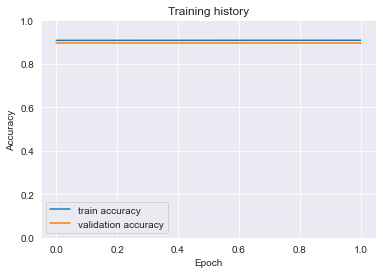

In [32]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [33]:
test_acc, _ = eval_model(
  bert_model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0.9177489177489178

In [40]:
import torch.nn.functional as F
def get_predictions(model, data_loader):
  model = model.eval()

  sequences = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sequence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs.logits, dim=1)
      probs = F.softmax(outputs.logits, dim=1)

      sequences.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sequences, predictions, prediction_probs, real_values

In [41]:
y_sequences, y_pred, y_pred_probs, y_test = get_predictions(
  bert_model,
  test_data_loader
)

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [42]:
a = y_test.numpy

In [43]:
someListOfLists = list(zip(y_sequences, y_test, y_pred, y_pred_probs ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob'])
# dff['Real']= pd.to_numeric(df["Real"])
dff

/var/folders/xq/pylr4t8d08g_cywhg3hhf02w0000gn/T/ipykernel_10233/4165259423.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  npa = np.asarray(someListOfLists)


,tweet,Real,Predicted,Pred-prob
0,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
1,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
2,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
3,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
4,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
...,...,...,...,...
226,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
227,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
228,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"
229,[CLS]SEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSEPSE...,tensor(0),tensor(0),"[tensor(0.9942), tensor(0.0058)]"


In [44]:
readme = ""
encoded_tweet = bert_tokenizer.encode_plus(
  readme,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)


output = bert_model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)
print(f'README text: {readme}')
print(f'Prediction  : {prediction}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TypeError: max() received an invalid combination of arguments - got (SequenceClassifierOutput, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
